### Imports


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import glob
import os


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, BatchNormalization,MaxPooling2D, GlobalAveragePooling2D, Resizing, Rescaling
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from keras.models import load_model
import tensorflow.keras.utils


### Data prep and EDA

In [2]:
path = 'kaggle/archive/train/'
image_dir = Path(path)

In [3]:
filepaths = list(image_dir.glob(r'*/*.jpg')) 
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
species_types=os.listdir(path)


In [4]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels,name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels],axis=1)
# image_df

In [5]:
s_top15 = image_df['Label'].value_counts(ascending=False)
s_top15

RUFOUS TREPE               274
HOUSE FINCH                248
D-ARNAUDS BARBET           233
OVENBIRD                   233
ASIAN GREEN BEE EATER      220
                          ... 
GO AWAY BIRD               131
INDIAN BUSTARD             131
PATAGONIAN SIERRA FINCH    130
RED TAILED THRUSH          130
SNOWY PLOVER               130
Name: Label, Length: 510, dtype: int64

In [6]:
top_list = s_top15.index.to_list()
top_list = top_list[0:15]
top_list

['RUFOUS TREPE',
 'HOUSE FINCH',
 'D-ARNAUDS BARBET',
 'OVENBIRD',
 'ASIAN GREEN BEE EATER',
 'SWINHOES PHEASANT',
 'WOOD DUCK',
 'CASPIAN TERN',
 'RED BILLED TROPICBIRD',
 'WOOD THRUSH',
 'FRILL BACK PIGEON',
 'MERLIN',
 'PYRRHULOXIA',
 'ORNATE HAWK EAGLE',
 'LAUGHING GULL']

In [7]:
image_df = image_df[image_df['Label'].isin(top_list)]
image_df.reset_index(inplace=True)


In [48]:
image_df

,index,Filepath,Label
0,6267,kaggle\archive\train\ASIAN GREEN BEE EATER\1.jpg,ASIAN GREEN BEE EATER
1,6268,kaggle\archive\train\ASIAN GREEN BEE EATER\10.jpg,ASIAN GREEN BEE EATER
2,6269,kaggle\archive\train\ASIAN GREEN BEE EATER\100...,ASIAN GREEN BEE EATER
3,6270,kaggle\archive\train\ASIAN GREEN BEE EATER\101...,ASIAN GREEN BEE EATER
4,6271,kaggle\archive\train\ASIAN GREEN BEE EATER\102...,ASIAN GREEN BEE EATER
...,...,...,...
3313,80920,kaggle\archive\train\WOOD THRUSH\207.jpg,WOOD THRUSH
3314,80921,kaggle\archive\train\WOOD THRUSH\208.jpg,WOOD THRUSH
3315,80922,kaggle\archive\train\WOOD THRUSH\209.jpg,WOOD THRUSH
3316,80923,kaggle\archive\train\WOOD THRUSH\210.jpg,WOOD THRUSH


In [9]:
train_df, test_df = train_test_split(image_df, 
                                     test_size=0.2,
                                     shuffle=True,
                                     random_state=101)

In [10]:
train_gen = ImageDataGenerator(
    # due to the nature of mobilnetv2 the input images have to be at least 224x224
    # loaded with a range [0,1]
    # and then normalized using mean = [0.485, 0.456, 0.406] 
    # and std = [0.229, 0.224, 0.225]
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [11]:
# Split the data into three categories
train_images = train_gen.flow_from_dataframe(
    dataframe=train_df, # training data from test train split
    x_col='Filepath', # flow from dataframe(ffd), setting x
    y_col='Label', # ffd setting y (need this as we have set class_mode to categorical)
    target_size=(224,224), # set image size
    color_mode='rgb', # default
    class_mode='categorical',# this is multi class classification problem
    batch_size=32, # batch size
    shuffle=True, # set to true for train/val. set to false for test
    seed=30, # random seed set
    subset='training' # needs to be set as validation is used
)

val_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=30,
    subset='validation' 
)

test_images = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2124 validated image filenames belonging to 15 classes.
Found 530 validated image filenames belonging to 15 classes.
Found 664 validated image filenames belonging to 15 classes.


In [12]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
    # incase some of the images are not the right size
    Resizing(224,224),
    # rescale the images to be in the range [0,1]
    Rescaling(1.0/255),
])

### Model
This model will be an implementation of transfer learning. It will use the MobileNetV2 model as the base model. This implementation will be as follows:
- The layers from this base model will be frozen.
- Some new trainable layers are added to the model
- The new layers are trained on the bird dataset
- An optional step at the end is fine-tuning 

[Keras transfer learning guide ](https://keras.io/guides/transfer_learning/)


In [13]:
# clear so a fresh model each time
tf.keras.backend.clear_session()

base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
# freezing the base model layers
base_model.trainable=False

In [14]:
inputs = base_model.input # base model loaded
x = resize_and_rescale(inputs) #apply resize and rescale
x = Dense(256, activation='relu')(base_model.output) # add a layer
x = Dropout(0.2)(x) # add a dropout layer
x = Dense(256,activation='relu')(x)
x = Dropout(0.2)(x)

# outputs = 15 classes with softmax activation due to classification problem
outputs = Dense(15,activation='softmax')(x) 

model =  Model(inputs=inputs, outputs=outputs)

# model.summary()

In [ ]:
# Output exceeds the size limit. Open the full output data in a text editor
# Model: "model_1"
# __________________________________________________________________________________________________
#  Layer (type)                   Output Shape         Param #     Connected to                     
# ==================================================================================================
#  input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
#                                 )]                                                                
                                                                                                  
#  Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
#                                 )                                                                 
                                                                                                  
#  bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
#                                 )                                                                 
                                                                                                  
#  Conv1_relu (ReLU)              (None, 112, 112, 32  0           ['bn_Conv1[0][0]']               
#                                 )                                                                 
                                                                                                  
#  expanded_conv_depthwise (Depth  (None, 112, 112, 32  288        ['Conv1_relu[0][0]']             
#  wiseConv2D)                    )                                                                 
                                                                                                  
#  expanded_conv_depthwise_BN (Ba  (None, 112, 112, 32  128        ['expanded_conv_depthwise[0][0]']
#  tchNormalization)              )                                                                 
                                                                                                  
#  expanded_conv_depthwise_relu (  (None, 112, 112, 32  0          ['expanded_conv_depthwise_BN[0][0
#  ReLU)                          )                                ]']                              
                                                                                                  
# ...
# Total params: 2,655,567
# Trainable params: 397,583
# Non-trainable params: 2,257,984

In [15]:
# initially used BinaryCrossentropy
# not a suitable loss function for this dataset
# loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [16]:
model.compile(loss=loss,optimizer='adam',metrics=['accuracy'])

In [17]:
epochs = 5

In [18]:
history = model.fit(
    train_images, # this is essential train_X and train_y
    steps_per_epoch=len(train_images),
    validation_data=val_images, # this is val_X and val_y
    validation_steps=len(val_images),
    epochs=epochs,
    
)

Epoch 1/5


C:\Users\Cian-work\AppData\Roaming\Python\Python39\site-packages\keras\backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


67/67 [==============================] - 29s 399ms/step - loss: 0.7823 - accuracy: 0.7627 - val_loss: 0.2721 - val_accuracy: 0.9019
Epoch 2/5
67/67 [==============================] - 25s 375ms/step - loss: 0.1894 - accuracy: 0.9407 - val_loss: 0.1288 - val_accuracy: 0.9585
Epoch 3/5
67/67 [==============================] - 25s 377ms/step - loss: 0.1008 - accuracy: 0.9685 - val_loss: 0.0904 - val_accuracy: 0.9736
Epoch 4/5
67/67 [==============================] - 25s 376ms/step - loss: 0.0619 - accuracy: 0.9835 - val_loss: 0.1151 - val_accuracy: 0.9642
Epoch 5/5
67/67 [==============================] - 26s 391ms/step - loss: 0.0488 - accuracy: 0.9854 - val_loss: 0.1039 - val_accuracy: 0.9698


In [19]:
# saving the model and history

history.model.save('mnv2_cc_loss_model.tf')
np.save('mobilenetv2_cc_loss.npy',history.history)

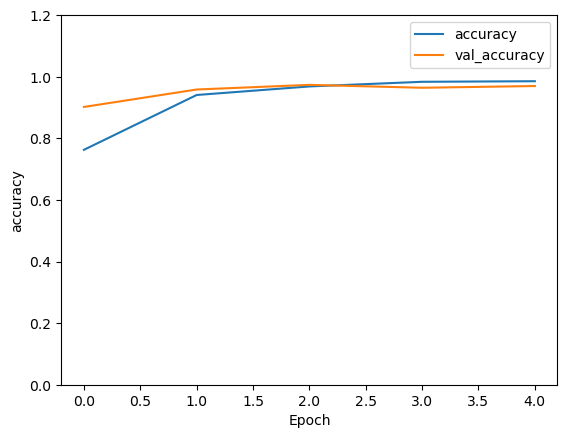

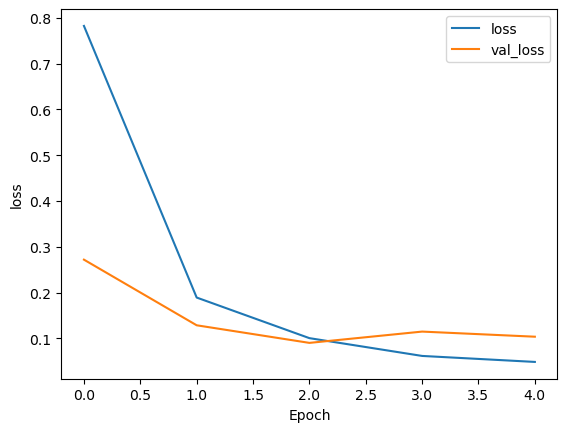

In [21]:
def plotter(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  

plotter(history, 'accuracy')
plt.ylim(0,1.2)
plt.show()
plotter(history, 'loss')
plt.show()


21/21 [==============================] - 7s 308ms/step - loss: 0.1395 - accuracy: 0.9518
Accuracy on test set: 95.18%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       0.92      0.90      0.91        49
           2       0.98      0.96      0.97        51
           3       0.98      0.91      0.94        45
           4       0.94      0.96      0.95        46
           5       0.90      0.95      0.92        38
           6       0.87      0.94      0.91        36
           7       0.88      1.00      0.94        44
           8       0.92      0.94      0.93        48
           9       1.00      1.00      1.00        27
          10       0.97      0.86      0.91        42
          11       0.98      1.00      0.99        52
          12       1.00      1.00      1.00        33
          13       0.98      1.00      0.99        46
          14       0.98      0.88      0.93        50

    accuracy    

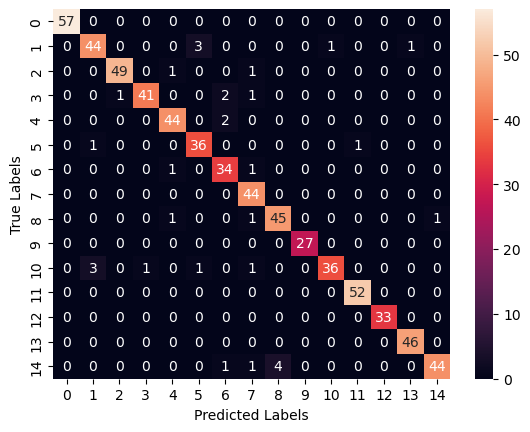

In [22]:
# setting up preds
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred,axis=1) # used to select the class with the highest probability


# converting the y_test label(a string) to the class index
species = test_images.class_indices
y_test = list(test_df.Label)
y_test = [species[bird_class] for bird_class in y_test]


# metrics, reporting and viz
results = model.evaluate(test_images)
print(f'Accuracy on test set: {results[1]*100:.2f}%')
report = classification_report(y_test, y_pred,output_dict = True)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [35]:
def predictor(model,train_df,species_dict):
        
        rand = train_df.sample()
        # print(rand)
        image_path = str(rand['Filepath'].values[0])
        label = rand['Label'].values[0]
        # load the img and covert to an array
        img = load_img(image_path)
        img = img_to_array(img)
        # make it correct size and preprocess it
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        # make a prediction
        img_pred = model.predict(img,verbose=0)
        img_pred = np.argmax(img_pred,axis=1)
        # get the class corresponding to the class index
        bird_class = [k for k,v in species_dict.items() if img_pred == v]
        
        fig, ax = plt.subplots(1,1, figsize = (10,6))
        ax.imshow(plt.imread(image_path))
        ax.set_title(f'True:{label}\nPred:{bird_class[0]}')
        ax.axis('off')
        # return print(f'Predicted classification: {bird_class[0]}') 

        
        


In [39]:
path = 'kaggle/archive/test/'
image_dir = Path(path)

In [ ]:
# loading model and history
model = load_model('mnv2_cc_loss_model.tf')
history=np.load('mobilenetv2_cc_loss.npy',allow_pickle='TRUE').item()

In [40]:
filepaths = list(image_dir.glob(r'*/*.jpg')) 
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
species_types=os.listdir(path)

In [41]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels,name='Label')

# Concatenate filepaths and labels
test_image_df = pd.concat([filepaths, labels],axis=1)
# image_df

In [42]:
test_image_df = test_image_df[test_image_df['Label'].isin(top_list)]
test_image_df.reset_index(inplace=True)


In [43]:
test_dir_images = test_gen.flow_from_dataframe(
    dataframe=test_image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 75 validated image filenames belonging to 15 classes.


3/3 [==============================] - 1s 211ms/step - loss: 0.0154 - accuracy: 1.0000
Accuracy on test set: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5

    accuracy     

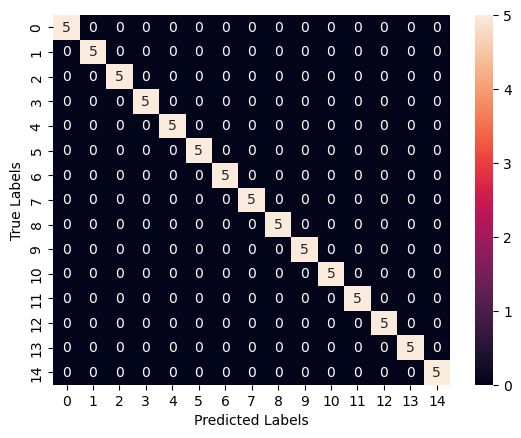

In [44]:
y_pred = model.predict(test_dir_images)
y_pred = np.argmax(y_pred,axis=1) # used to select the class with the highest probability


# converting the y_test label(a string) to the class index
species = test_dir_images.class_indices
y_test = list(test_image_df.Label)
y_test = [species[bird_class] for bird_class in y_test]


# metrics, reporting and viz
results = model.evaluate(test_dir_images)
print(f'Accuracy on test set: {results[1]*100:.2f}%')
report = classification_report(y_test, y_pred,output_dict = True)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


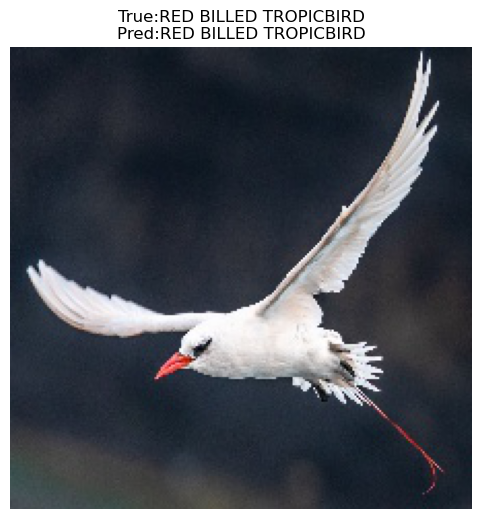

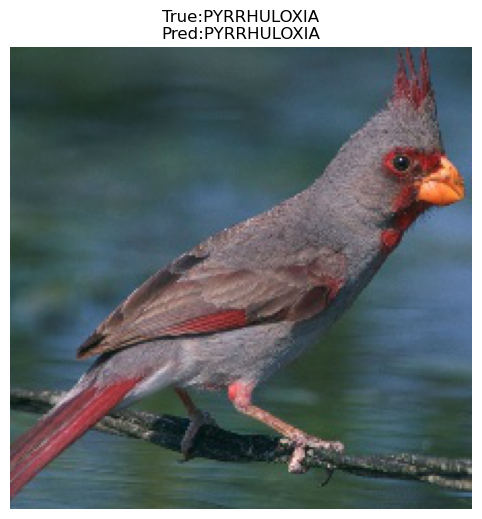

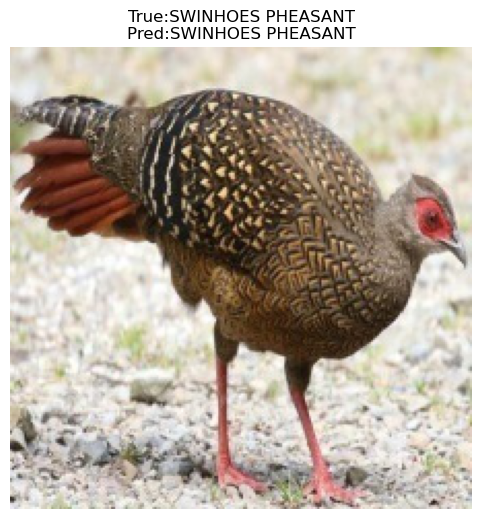

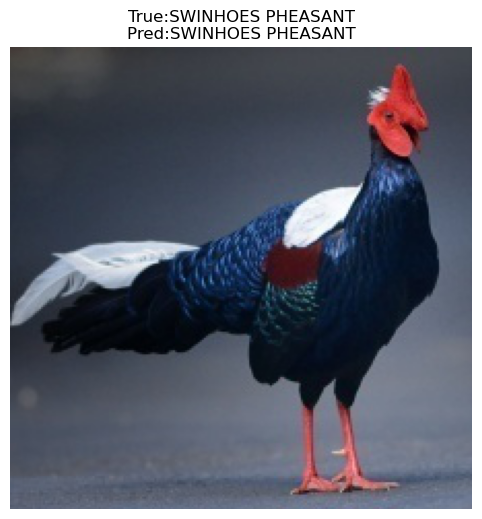

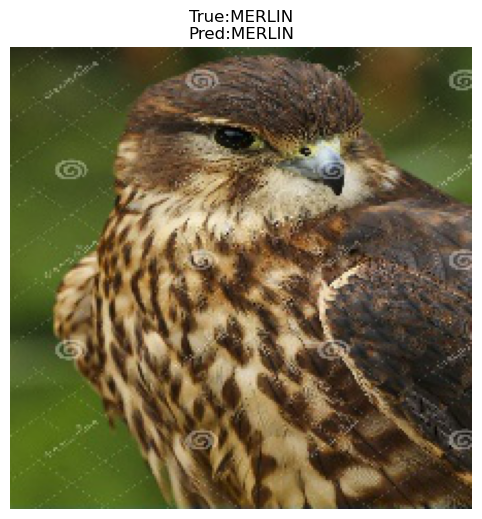

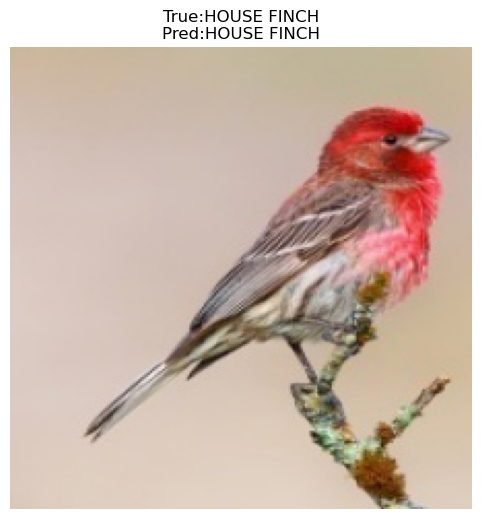

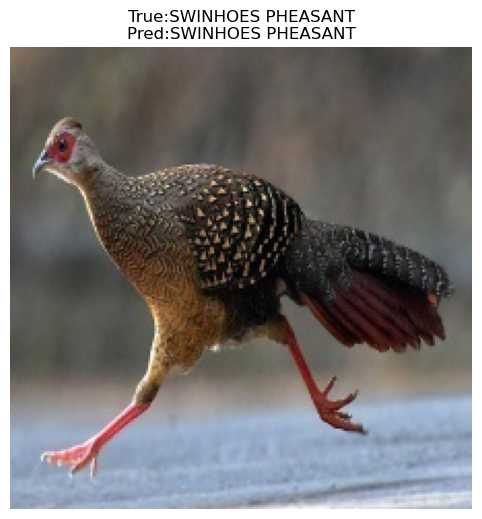

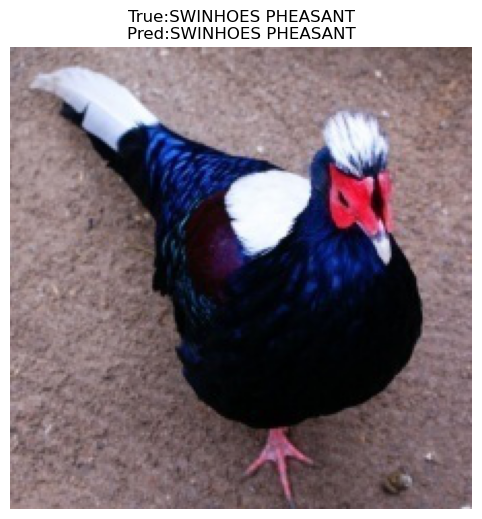

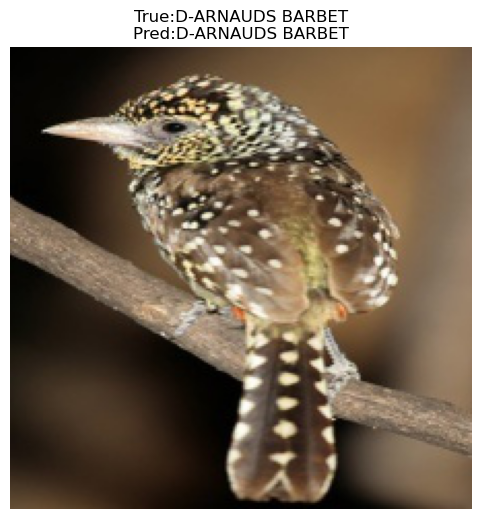

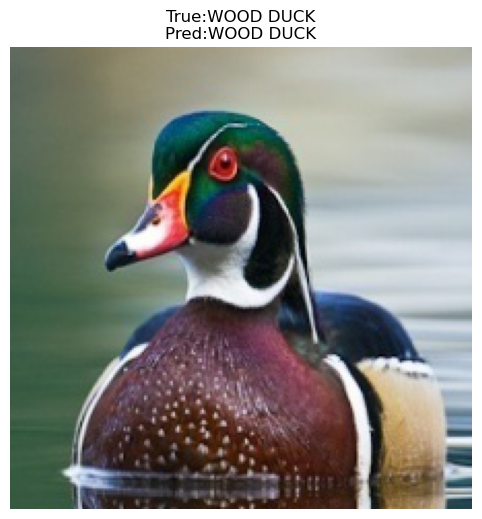

In [47]:
for i in range(10):
    predictor(model,test_image_df,species)
    plt.show()
    
